In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import keras_cv
import tensorflow as tf
from keras_cv import bounding_box, visualization
from keras_cv.backend import keras
from keras_cv.backend import ops
from keras_cv.models.object_detection.yolo_v8.yolo_v8_detector import decode_regression_to_boxes, get_anchors, dist2bbox

import numpy as np
import requests
from PIL import Image

def resize_image_and_padding(path, expected_size):
    if path.startswith('http'):
        image = Image.open(requests.get(path, stream=True).raw)
    else:
        image = Image.open(path)
        
    basew, baseh = expected_size
   
    if image.size[0] > image.size[1]:
        percent = basew / float(image.size[0])
        size = int((float(image.size[1]) * float(percent)))
        image = image.resize((basew, size))
    else:
        percent = baseh / float(image.size[1])
        size = int((float(image.size[0]) * float(percent)))
        image = image.resize((size, baseh))

    img = np.array(image, dtype='float32')
    
    height, width = img.shape[0:2]
    margin = [np.abs(height - width) // 2, np.abs(height - width) // 2]
    if np.abs(height - width) % 2 != 0:
        margin[0] += 1
    
    if height < width:
        margin_list = [margin, [0, 0]]
    else:
        margin_list = [[0, 0], margin]
        
    if len(img.shape) == 3:
        margin_list.append([0,0])
  
    return np.pad(img, margin_list, mode='constant')



2023-12-15 06:00:24.381981: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-15 06:00:24.407542: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 06:00:24.407576: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 06:00:24.407592: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 06:00:24.412297: I tensorflow/core/platform/cpu_feature_g

Using TensorFlow backend


In [ ]:
image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS-ObvMt0h7uaiN_9hhppNRqg0h2qcjkcdRdQ&usqp=CAU"
class_mapping = {
    0: "cat",
    1: "dog",
}

backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco",
    load_weights=True
)
backbone.trainable = False
model = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xywh",
    backbone=backbone,
    fpn_depth=2,
)

print(model.summary())


image = resize_image_and_padding(image_url, (480, 480))
image = np.expand_dims(image, 0)

y_pred = model.predict(image, verbose=-1)
y_pred = bounding_box.to_ragged(y_pred)
visualization.plot_bounding_box_gallery(
    image,
    value_range=(0, 255),
    rows=0,
    cols=0,
    y_pred=y_pred,
    scale=5,
    font_scale=0.5,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)
print(image.shape)

keras.saving.save_model(model, "./test.keras")

In [ ]:

class DecodePredictions(keras.layers.Layer):
    def __init__(self, bounding_box_format, **kwargs):
        super().__init__(**kwargs)
        self.bounding_box_format = bounding_box_format 
        self.built = True
        
    def call(self, inputs):
        images, boxes, scores = inputs
        boxes = decode_regression_to_boxes(boxes)
        anchor_points, stride_tensor = get_anchors(image_shape=images.shape[1:])
        stride_tensor = ops.expand_dims(stride_tensor, axis=-1)
        box_preds = dist2bbox(boxes, anchor_points) * stride_tensor
        box_preds = bounding_box.convert_format(
                box_preds,
                source="xyxy",
                target=self.bounding_box_format,
                images=images,
        )
        nms = keras_cv.layers.MultiClassNonMaxSuppression(
            bounding_box_format=self.bounding_box_format,
            from_logits=False,
            iou_threshold=0.7,
            confidence_threshold=0.2
        )(box_preds, scores, images)
        return nms
        

load_model = keras.saving.load_model("test.keras")

outputs = DecodePredictions(bounding_box_format='xywh', name='decode_predictions')([load_model.layers[0].input, load_model.layers[-2].output, load_model.layers[-1].output])
integrate_model = keras.Model(inputs=load_model.layers[0].input, outputs=outputs, name='integrate_model')

integrate_model.trainable = False
integrate_model.summary()

y_pred = integrate_model(image)
y_pred = bounding_box.to_ragged(y_pred)
visualization.plot_bounding_box_gallery(
    image,
    value_range=(0, 255),
    rows=0,
    cols=0,
    y_pred=y_pred,
    scale=5,
    font_scale=0.5,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

keras.saving.save_model(integrate_model, "integrate.keras")


In [ ]:
import tf2onnx
# onnx 모델 생성시 이미지 사이즈 고정이 필수...
#spec = (tf.TensorSpec((None, None, None, 3), tf.float32, name="input"),)
spec = (tf.TensorSpec((None, 480, 480, 3), tf.float32, name="input"),)
model_proto, _ = tf2onnx.convert.from_keras(integrate_model, output_path='integrate.onnx', input_signature=spec)
output_names = [n.name for n in model_proto.graph.output]
print(output_names)
model_proto


In [22]:
import onnxruntime as ort
print(ort.get_device())
session = ort.InferenceSession('integrate.onnx', providers=['CPUExecutionProvider'])
print('inputs: {}'.format(', '.join([i.name for i in session.get_inputs()])))
print('outputs: {}'.format(', '.join([o.name for o in session.get_outputs()])))

print(image.shape, type(image))
inputs = {session.get_inputs()[0].name: image}
output_names = [o.name for o in session.get_outputs()]
result = session.run(output_names, inputs)
y_pred = {
    'boxes': np.array(result[0]),
    'confidence': np.array(result[1]),
    'classes': np.array(result[2]),
    'num_detections': np.array(result[3]),
}


GPU
inputs: input
outputs: decode_predictions, decode_predictions_1, decode_predictions_2, decode_predictions_3
(1, 480, 480, 3) <class 'numpy.ndarray'>


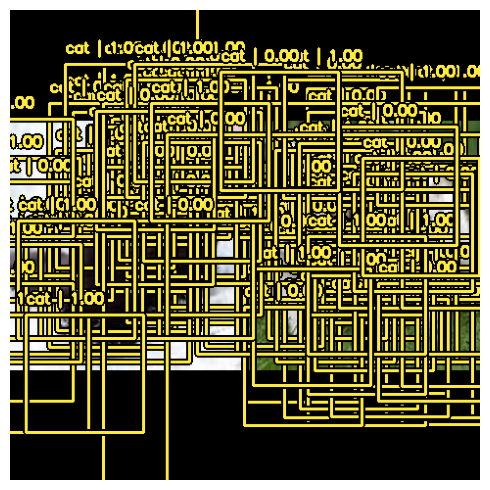

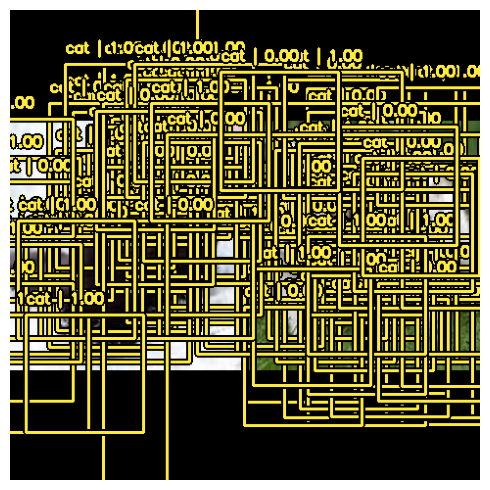

In [23]:
y_pred = bounding_box.to_ragged(y_pred)
visualization.plot_bounding_box_gallery(
    image,
    value_range=(0, 255),
    rows=0,
    cols=0,
    y_pred=y_pred,
    scale=5,
    font_scale=0.5,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)